Are innovation activities good export status predictors for businesses in the developing world? This simple Machine Learnine project attempts to answer that question. Using ecuadorian business-level data and using some export determinant features, I trained an export status (Exporter / Non exporter) supervised learning classifier.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

In [3]:
#enai = pd.read_csv('bdd_INN_2015.csv', sep=';', error_bad_lines=False) # larga
dir = r'bdd_INN_2015.dta'
enai = pd.read_stata(dir) # corta
enai.head(3)

,id_empresa,cod_provincia,ciiu1,ciiu2,ciiu3,sector,tamaño,ii_1,ii_2,ii_3,...,xv_5_a_2,xv_5_a_3,xv_5_a_4,xv_5_a_5,xv_5_b_1,xv_5_b_2,xv_5_b_3,xv_5_b_4,xv_5_b_5,fexp
0,1.358264e+10,01,G,G45,G452,comercio,pequeña,no,NaN,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.404494
1,1.358267e+10,01,I,I55,I551,servicios,pequeña,no,NaN,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.527397
2,1.358277e+10,01,C,C14,C141,manufactura,pequeña,no,NaN,no,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.213592


### Useful functions

In [4]:
def from_label_to_integer(dta_dir, df_var_name, var_list):
    """
    DESCRIPTION:
    By default, .dta files imported to pandas use their "data labels" as categorical values, instead of their associated  integers. Sometimes, this might no be the most useful scenario, because the user might need the latter instead. This function fixes that issue.
    PARAMETERS:
    :param dta_dir: (str) Directory of the .dta file.
    :param df_var_name: (pandas.DataFrame) variable where the main DataFrame is saved. This DataFrame's directory should be the same assigned to dta_dir.
    :param var_list: List of columns (as str) belonging to df_var_name, whose values need to be changed from categories to their associated integers; for example: list = ['a', 'b', 'c']
    RETURNS:
    :return: Inplace associated keys / integers.
    NOTES:
    1) pandas library needs to be previously imported: import pandas as pd
    2) The work DataFrame has to be already defined in a variable, passed to the function in the df_var_name parameter.
    """
    with pd.read_stata(dta_dir, iterator=True) as df:
        label_dict = df.value_labels()
    pd.options.mode.chained_assignment = None
    for var in var_list:
        df_var_name[var] = df_var_name[var].astype('str')
        for key, inner_dict in label_dict.items():
            if var == key:
                for k, label in inner_dict.items():
                    for index, row in df_var_name.iterrows():
                        if row[var] == label:
                            df_var_name[var][index] = int(k)
                        elif row[var] == 'nan':
                            df_var_name[var][index] = np.nan
        df_var_name[var] = pd.to_numeric(df_var_name[var], errors='coerce', downcast='integer')

### Data cleaning

In [5]:
print('Starting sample: {} observations.'.format(enai.shape[0]))

enai['id_empresa'] = enai['id_empresa'].astype('str')

# a) Drop if employment == 0:
enai.drop(enai[enai['ii_9_d_2012'] == 0].index, inplace=True)
enai.drop(enai[enai['ii_9_d_2013'] == 0].index, inplace=True)
enai.drop(enai[enai['ii_9_d_2014'] == 0].index, inplace=True)
# 218 rows dropped.

# b) Drop if sales == 0:
enai = enai.rename(columns={'ii_9_a_2012': 'sales_2012', 'ii_9_a_2013': 'sales_2013', 'ii_9_a_2014': 'sales_2014'})
enai.drop(enai[enai['sales_2012'] == 0].index, inplace=True)
enai.drop(enai[enai['sales_2013'] == 0].index, inplace=True)
enai.drop(enai[enai['sales_2014'] == 0].index, inplace=True)
# 75 rows dropped.

# c) Drop I+D expenditure outliers:

enai['id_mean'] = (enai['v_1_a_2012'] + enai['v_1_a_2013'] + enai['v_1_a_2014'] + enai['v_1_b_2012'] + enai['v_1_b_2013'] + enai['v_1_b_2014']) / 6
enai = enai[enai['id_mean'] < 1333333]

enai['id_mean_low'] = 0
pd.options.mode.chained_assignment = None # skips 'SettingWithCopyWarning'.

for index, row in enai.iterrows():
    if row['id_mean'] < 100:
        enai['id_mean_low'][index] = 1
    if row['id_mean'] < 0.5:
        enai['id_mean_low'][index] = 0

enai.drop(enai[enai['id_mean_low'] == 1].index, inplace=True) # Drops too low I+D mean expenditures. 50 rows dropped.

enai['others_mean'] = (enai['v_4_total_2012'] + enai['v_4_total_2013'] + enai['v_4_total_2014'])/3
enai = enai[enai['others_mean'] < 15000000] # Drops too high "other innovative" mean expenditures. 5 rows dropped.

# I+D Intensity
enai['sales_mean'] = (enai['sales_2012'] + enai['sales_2013'] + enai['sales_2014'])/3
enai['id_mean_div_sales_mean'] = enai['id_mean'] / enai['sales_mean']
enai = enai[enai['id_mean_div_sales_mean'] < 0.3] # 2 rows dropped.

# d) Fixed Capital Investment (mean)
enai['fixed_cap_inv_mean'] = (enai['ii_9_c_2012'] + enai['ii_9_c_2013'] + enai['ii_9_c_2014'])/3
enai['k_inv_div_sales_mean'] = enai['fixed_cap_inv_mean'] / enai['sales_mean']
enai.drop(enai[enai['k_inv_div_sales_mean'] > 5].index, inplace=True) # 1 row dropped.
#enai = enai[enai['k_inv_div_sales_mean'] > 5]

# e) Market share (%)
enai['sector_sales'] = enai.groupby('ciiu3')['sales_mean'].transform('sum')
enai['mkt_share'] = enai['sales_mean'] / enai['sector_sales']
enai['mkt_share_sq'] = enai['mkt_share']**2
enai.drop(enai[enai['mkt_share'] > 0.95].index, inplace=True)

# f) Business Sectors
enai['business_sector'] = '0'
sector_dict = {1: ["C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C31", "C32"],
               2: ["C19", "C23", "C24", "C25", "C33", "S95"],
               3: ["C20", "C22", "C27", "C28", "C29", "C30"],
               4: ["C21", "C26"],
               5: ["B05", "B06", "B07", "B08"],
               6: ["J58", "J59", "J60", "J61", "J62", "J63", "K64", "K65", "K66", "M69", "M70", "M71", "M72", "M74", "M75", "N80", "P85", "Q86", "Q87", "Q88", "R90", "R91", "R92", "R93"],
               7: ["B09", "G45", "G46", "G47", "H49", "H50", "H51", "H52", "H53", "I55", "I56", "L68", "M73", "N77", "N78", "N79", "N81", "N82", "O84", "S94", "S96", "T97", "T98", "U99"],
               8: ["F41", "F42", "F43"],
               9: ["D35", "E35", "E36", "E37", "E38", "E39"],
               10: ["A01", "A02", "A03"]}

unique_ciiu2 = enai['ciiu2'].unique()
for index, value in enai.iterrows():
    for k, v in sector_dict.items():
        for code in v:
            if code in unique_ciiu2 and code == value['ciiu2']:
                enai['business_sector'][index] = k

enai = enai[enai['business_sector'] < 8] # 513 business belonging to non-exporters sectors 8 and 9 are dropped.

sector_dict = {x: 'sector_{}'.format(x) for x in range(1, 8)}

# Dummy variable column creation, per business sector:
for key, sector in sector_dict.items():
    enai[sector] = 0
    for index, value in enai.iterrows():
        if key == value['business_sector']:
            enai[sector][index] = 1

# for key, sector in sector_dict.items():
#     print(sector, ": ", enai[sector].mean())
enai['business_sector'] = enai['business_sector'].astype('category')

print('Final sample: {} observations.'.format(enai.shape[0]))

Starting sample: 6275 observations.
Final sample: 5381 observations.


### Feature engineering

In [6]:
# 1. Work productivity as log of sales per employee:
enai['ln_prod_2012'] = np.log(enai['sales_2012'] / enai['ii_9_d_2012']) # Lagged productivity
enai['ln_prod_2014'] = np.log(enai['sales_2014'] / enai['ii_9_d_2014']) # Period productivity

# 2. Lagged size of the business as log of number of employees:
enai['size_2012'] = np.log(enai['ii_9_d_2012'])

# 3. Lagged Fixed capital investment dummy: 1  1 for observations with 2012 fixed capital investment; 0 wise.
enai['fki_2012'] = 0
enai.loc[enai['ii_9_c_2012'] > 0, 'fki_2012'] = 1

# 4. Foreign Investment:  1 for observations with any foreign investment in period; 0 otherwise.
enai['foreign_inv'] = enai['ii_4'] / 100
enai.loc[enai['foreign_inv'] > 0, 'foreign_inv'] = 1
enai.loc[enai['foreign_inv'] ==0, 'foreign_inv'] = 0

# 5. Cooperation

# First, convert categorical 'cooperation' variable columns to booleans, keeping NaN values:
alphabet_list = 'abcdefghij'
viii_2_list = ['viii_2_{}'.format(x) for x in alphabet_list]
for var in viii_2_list:
    enai[var] = enai[var].astype('str')
    for index, row in enai.iterrows():
        if row[var] == 'si ha cooperado':
            enai[var][index] = int(1)
        elif row[var] == 'no ha cooperado':
            enai[var][index] = int(0)
        else:
            enai[var][index] = np.nan

# Second, create 2 variables that summarize if a business cooperated in any form (1) or not at all (0):
coop_all_0 = (enai['viii_2_a'] == 0) & (enai['viii_2_b'] == 0) & (enai['viii_2_c'] == 0) & (enai['viii_2_d'] == 0) & (enai['viii_2_e'] == 0) & (enai['viii_2_f'] == 0) & (enai['viii_2_g'] == 0) & (enai['viii_2_h'] == 0) & (enai['viii_2_i'] == 0) & (enai['viii_2_j'] == 0)
coop_any_1 = (enai['viii_2_a'] == 1) | (enai['viii_2_b'] == 1) | (enai['viii_2_c'] == 1) | (enai['viii_2_d'] == 1) | (enai['viii_2_e'] == 1) | (enai['viii_2_f'] == 1) | (enai['viii_2_g'] == 1) | (enai['viii_2_h'] == 1) | (enai['viii_2_i'] == 1) | (enai['viii_2_j'] == 1)

# Third, create a summary cooperation variable. All NaNs will be businesses that do no innovate (check Methodology);
# 0 wil be businesses that do innovate but don't cooperate and 1 businesses that do both. That criteria will be
# used later on.
enai['cooperation'] = np.nan
enai.loc[coop_all_0, 'cooperation'] = 0
enai.loc[coop_any_1, 'cooperation'] = 1

# Fourth, create a 'province cooperation' variable, which is the 'cooperation' aggregate mean per province.
enai['cooperation_2'] = enai['cooperation'].replace(np.nan, 0)
enai['province_coop'] = enai.groupby('cod_provincia')['cooperation_2'].transform('mean')

# 6. Export propensity / intensity variables.

# 6.1. Export intensity: lagged (2012) and result (2014)
enai['export_int_2012'] = enai['ii_9_b_2012'] / enai['sales_2012']
enai['export_int_2014'] = enai['ii_9_b_2014'] / enai['sales_2014']

# 6.2. Export propensity: lagged (2012) and result (2014)
enai['export_pro_2012'] = 0
enai.loc[enai['export_int_2012'] > 0, 'export_pro_2012'] = 1
enai['export_pro_2014'] = 0
enai.loc[enai['export_int_2014'] > 0, 'export_pro_2014'] = 1

# 7. ID Investment: A dummy variable that indicates if a business invested in I+D during 2012:

enai['id_2012'] = 0
enai.loc[(enai['v_1_total_2012']) > 0, 'id_2012'] = 1

# 8. Other innovation investment: A dummy variable that indicates if a business invested in I+D during 2012:

enai['other_2012'] = 0
enai.loc[(enai['v_4_total_2012']) > 0, 'other_2012'] = 1

# 9. Innovation dummy: Indicates if a business reports any innovation activity during 2012-2014. To do so, we take
# the 'cooperation' variable, because 0s and 1s are innovative businesses and NaN are not.
enai['innovates'] = 0
enai.loc[~pd.isnull(enai['cooperation']), 'innovates'] = 1

# 10. Product and Process innovation dummy variables.

prod_proc_list = ['iv_1_a', 'iv_1_b']

for var in prod_proc_list:
    enai[var] = enai[var].astype('str')
    for index, value in enai.iterrows():
        if value[var] == 'si':
            enai[var][index] = 1
        elif value[var] == 'no':
            enai[var][index] = 0

# 10.1. Businesses which only innovated through products.
enai['product_inn_only'] = 0
prod_inn_only = (enai['iii_3_a_ventas'] + enai['iii_3_b_ventas'] > 0) & (enai['iv_1_a'] + enai['iv_1_b'] == 0)
enai.loc[prod_inn_only, 'product_inn_only'] = 1

# 10.2. Businesses which only innovated through processes.
enai['process_inn_only'] = 0
proc_inn_only = (enai['iv_1_a'] + enai['iv_1_b'] > 0) & (enai['iii_3_a_ventas'] + enai['iii_3_b_ventas'] == 0)
enai.loc[proc_inn_only, 'process_inn_only'] = 1

# 10.3. Product vs. Process innovators comparison variable: 0 for process innovators, 1 for product innovators.
enai['product_vs_process'] = np.nan
enai.loc[enai['product_inn_only'] == 1, 'product_vs_process'] = 1
enai.loc[enai['process_inn_only'] == 1, 'product_vs_process'] = 0

# 11. 'Introducer' dummy: Indicates if an innovative business introduced any new/improved product or process.
list = ['iii_1_a', 'iii_1_b', 'iv_1_a', 'viii_2_a']
from_label_to_integer(dta_dir=dir, df_var_name=enai, var_list=list)

enai['introducer'] = np.nan
enai.loc[(enai['iii_1_a'] == 1) | (enai['iii_1_b'] == 1) | (enai['iv_1_a'] == 1), 'introducer'] = 1
enai.loc[(enai['iii_1_a'] == 0) & (enai['iii_1_b'] == 0) & (enai['iv_1_a'] == 0) & ~(pd.isnull(enai['viii_2_a'])), 'introducer'] = 0





In [7]:
# 12. Feature variables DataFrame. Note that sector_4 "high-technology manufacturing industries" is left behind, as it is the reference category in the propensity score computations.
#X = enai[['ln_prod_2012', 'size_2012', 'fki_2012', 'foreign_inv', 'province_coop', 'export_pro_2012', 'id_2012', 'other_2012', 'sector_1', 'sector_2', 'sector_3', 'sector_5', 'sector_6', 'sector_7']]

X = enai[['ln_prod_2012', 'size_2012', 'fki_2012', 'foreign_inv', 'province_coop', 'export_pro_2012', 'id_2012', 'other_2012', 'business_sector']]

# 13. Target variable DataFrame.
y = enai['export_pro_2014']

### Principal Component Analysis

<AxesSubplot:>

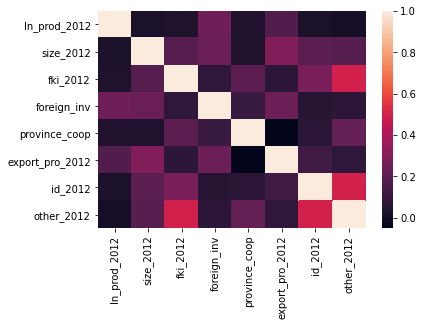

In [16]:
sns.heatmap(X.corr())

<AxesSubplot:xlabel='PC', ylabel='Variance explained'>

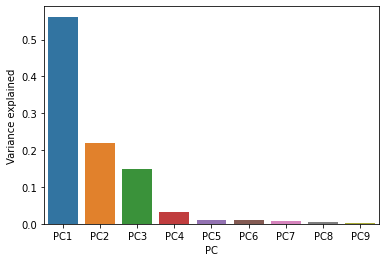

In [9]:
pca = PCA()
pca.fit_transform(X)
exp_variance = pca.explained_variance_ratio_

pc_cols = ['PC'+str(x) for x in range(1, len(X.columns) + 1)]

pca_df = pd.DataFrame({'PC': pc_cols, 'Variance explained': exp_variance})
sns.barplot(x = 'PC', y = 'Variance explained', data = pca_df)

### Machine Learning Classification Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print('Precision: ', precision_score(y_test, lr_pred))
print('Accuracy: ', accuracy_score(y_test, lr_pred))
print('Recall: ', recall_score(y_test, lr_pred))
print('F1: ', f1_score(y_test, lr_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, lr_pred))

Precision:  0.9439252336448598
Accuracy:  0.9746130030959752
Recall:  0.8744588744588745
F1:  0.9078651685393259
Confusion matrix:
 [[1372   12]
 [  29  202]]


In [12]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

print('Precision: ', precision_score(y_test, dt_pred))
print('Accuracy: ', accuracy_score(y_test, dt_pred))
print('Recall: ', recall_score(y_test, dt_pred))
print('F1: ', f1_score(y_test, dt_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, dt_pred))

Precision:  0.8616071428571429
Accuracy:  0.9572755417956657
Recall:  0.8354978354978355
F1:  0.8483516483516484
Confusion matrix:
 [[1353   31]
 [  38  193]]


In [13]:
dt = RandomForestClassifier(n_estimators = 200, random_state = 123, oob_score = True)
dt.fit(X_train, y_train)
rf_pred = dt.predict(X_test)

print('Precision: ', precision_score(y_test, rf_pred))
print('Accuracy: ', accuracy_score(y_test, rf_pred))
print('Recall: ', recall_score(y_test, rf_pred))
print('F1: ', f1_score(y_test, rf_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, rf_pred))

Precision:  0.9395348837209302
Accuracy:  0.9739938080495356
Recall:  0.8744588744588745
F1:  0.9058295964125561
Confusion matrix:
 [[1371   13]
 [  29  202]]


In [14]:
dt = RandomForestClassifier(n_estimators = 200, max_depth =  5, random_state = 123, oob_score = True)
dt.fit(X_train, y_train)
rf_pred = dt.predict(X_test)

print('Precision: ', precision_score(y_test, rf_pred))
print('Accuracy: ', accuracy_score(y_test, rf_pred))
print('Recall: ', recall_score(y_test, rf_pred))
print('F1: ', f1_score(y_test, rf_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, rf_pred))

Precision:  0.9439252336448598
Accuracy:  0.9746130030959752
Recall:  0.8744588744588745
F1:  0.9078651685393259
Confusion matrix:
 [[1372   12]
 [  29  202]]


In [15]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn_pred = dt.predict(X_test)

print('Precision: ', precision_score(y_test, knn_pred))
print('Accuracy: ', accuracy_score(y_test, knn_pred))
print('Recall: ', recall_score(y_test, knn_pred))
print('F1: ', f1_score(y_test, knn_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, knn_pred))

Precision:  0.9439252336448598
Accuracy:  0.9746130030959752
Recall:  0.8744588744588745
F1:  0.9078651685393259
Confusion matrix:
 [[1372   12]
 [  29  202]]
